In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import boxcox, spearmanr, kendalltau, norm, mstats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import datetime
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (18, 6)

from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_excel('BST_DataSet.xlsx', index_col=0)

In [3]:
df_train = df.iloc[:-12, :]
df_test = df.iloc[-12:, :]

In [4]:
df_train.head(5)

,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5532900.0,19307.7,30.08,20669
2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,5613700.0,19536.7,29.29,20680
2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,5647000.0,19788.7,28.43,22673
2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,5863400.0,20020.8,28.10,22519
2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5893400.0,20160.9,27.87,22779


In [5]:
df_test.head(5)

,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
2017-01-01,NaN,8.416190,10.00,0.79,6.50,54.89,166.43472,8628900.0,38016.8,59.96,34422
2017-02-01,NaN,8.830526,10.00,0.77,6.30,55.49,166.80087,8711600.0,38475.2,58.39,35497
2017-03-01,NaN,8.987727,9.75,0.80,5.91,51.97,167.01772,8697700.0,38555.2,58.10,37899
2017-04-01,NaN,8.655263,9.75,0.52,6.25,53.06,167.56887,8936600.0,38663.8,56.43,39225
2017-05-01,NaN,8.319500,9.25,0.76,6.10,50.87,168.18888,8907000.0,39222.9,57.17,39679


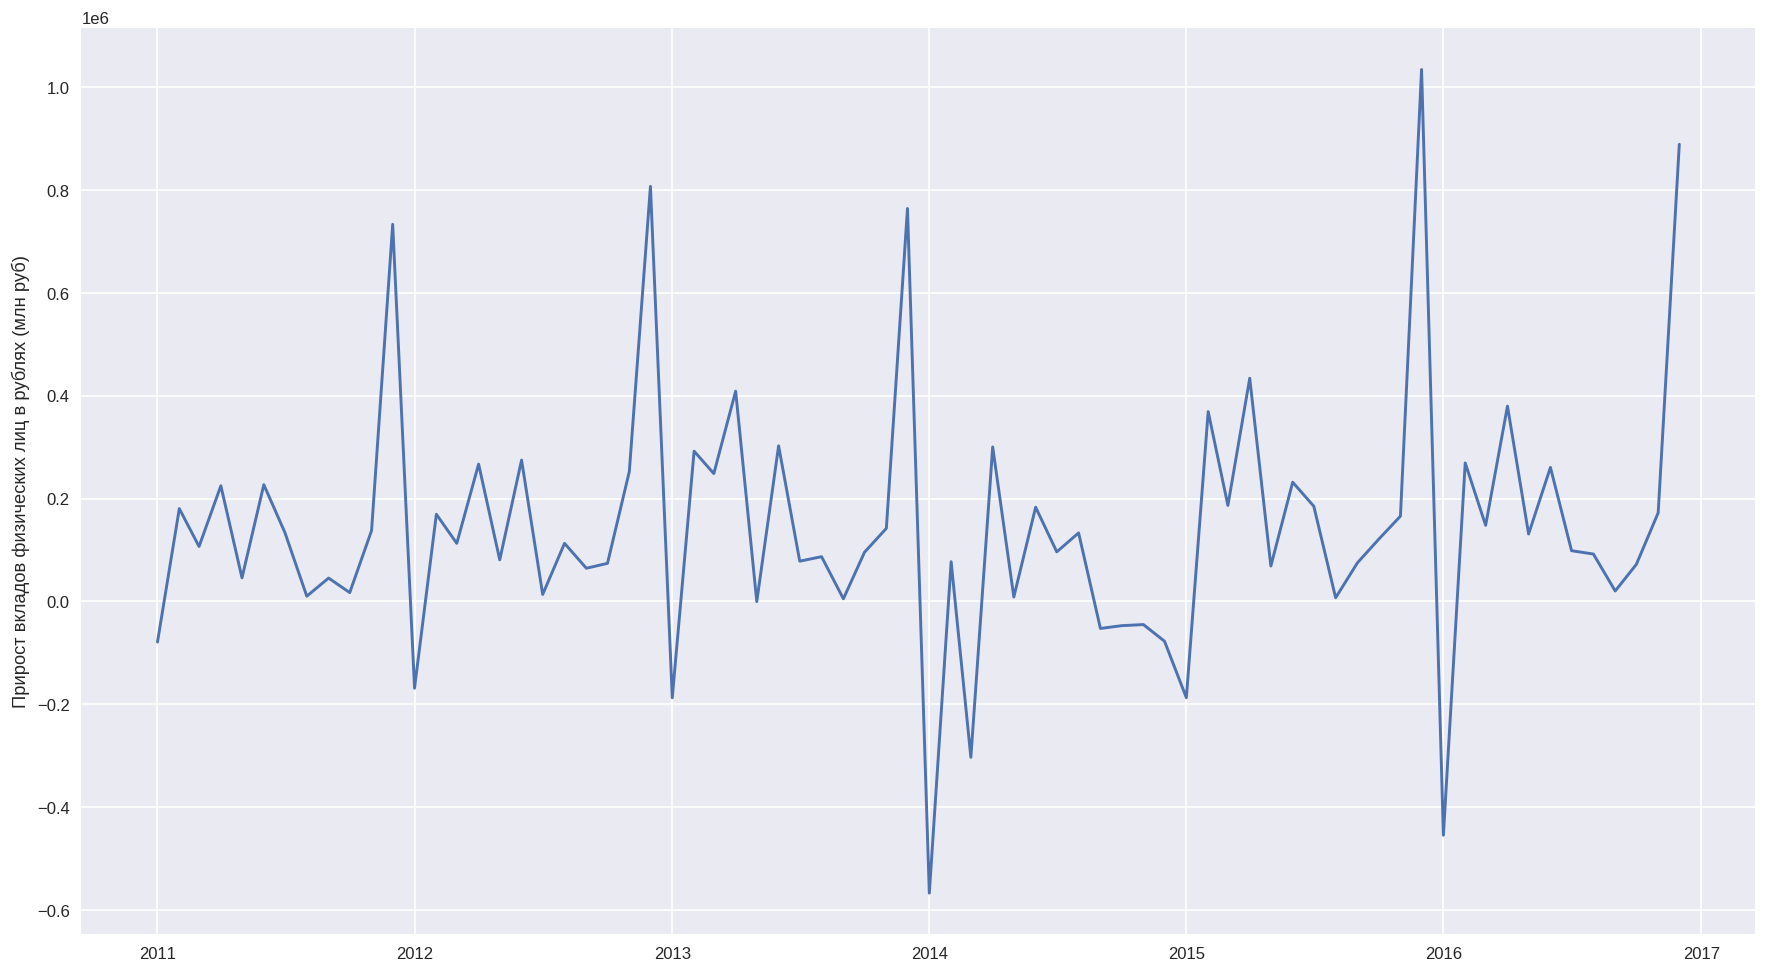

In [467]:
sns.lineplot(x=df_train.index, 
             y="Прирост вкладов физических лиц в рублях (млн руб)",
             data=df_train);

In [468]:
df_train['target'] = df_train['Прирост вкладов физических лиц в рублях (млн руб)'] - df_train['Прирост вкладов физических лиц в рублях (млн руб)'].min() + 10

In [469]:
def kpss_test(target):
    stat = kpss(target)[0]
    crit = kpss(target)[3]['5%']
    p_value = kpss(target)[1]
    if stat < crit:
        return (f'KPSS тест не отвергает гипотезу о стационарности, '
                f'Статистика {round(stat,3)} > критического значения {crit}, '
                f'p_value {p_value} < 0.05')
    else:
        return (f'KPSS тест отвергает гипотезу о стационарности, '
                f'Статистика {round(stat,3)} > критического значения {crit}, '
                f'p_value {p_value} > 0.05')

In [470]:
def adfuller_test(target):
    stat = adfuller(target)[0]
    crit = adfuller(target)[4]['5%']
    p_value = adfuller(target)[1]
    if stat > crit:
        return (f'Тест Дикки-Фуллера отвергает гипотезу о стационарности ряда, '# #  (есть единичные корни)
                f'Статистика {round(stat,3)} > критического значения {round(crit,3)}, '
                f'p_value: {round(p_value,3)}')
    else:
        return (f'Тест Дикки-Фуллера не отвергает гипотезу о стационарности ряда, ' #  (нет единичных корней)
                f'Статистика {round(stat,3)} < критического значения {round(crit,3)}, '
                'p_value: {round(p_value,3)}')

In [471]:
kpss_test(df_train.target)

'KPSS тест не отвергает гипотезу о стационарности, Статистика 0.088 > критического значения 0.463, p_value 0.1 < 0.05'

In [472]:
adfuller_test(df_train.target)

'Тест Дикки-Фуллера отвергает гипотезу о стационарности ряда, Статистика -1.562 > критического значения -2.912, p_value: 0.502'

Ряд не стационарен

In [473]:
boxcox(df_train.target)[0]

array([2.27580791e+04, 3.12396725e+04, 2.89235852e+04, 3.26083355e+04,
       2.69555708e+04, 3.26734695e+04, 2.97772754e+04, 2.57806554e+04,
       2.69406070e+04, 2.60118640e+04, 2.99052699e+04, 4.71383898e+04,
       1.95700287e+04, 3.08986989e+04, 2.91172763e+04, 3.38887531e+04,
       2.80913481e+04, 3.41248533e+04, 2.58933676e+04, 2.91171172e+04,
       2.75635996e+04, 2.78699807e+04, 3.34500171e+04, 4.91142002e+04,
       1.88902888e+04, 3.46466692e+04, 3.33319933e+04, 3.80856132e+04,
       2.54326253e+04, 3.49551612e+04, 2.80074712e+04, 2.82875073e+04,
       2.56114334e+04, 2.85658206e+04, 3.00410374e+04, 4.79644934e+04,
       6.10403983e+00, 2.79728705e+04, 1.44104248e+04, 3.48921577e+04,
       2.57285846e+04, 3.13253508e+04, 2.85901207e+04, 2.97612390e+04,
       2.36670102e+04, 2.38519307e+04, 2.39263186e+04, 2.28126771e+04,
       1.88917293e+04, 3.69260037e+04, 3.14301895e+04, 3.88110671e+04,
       2.77024557e+04, 3.28212460e+04, 3.13815671e+04, 2.56790355e+04,
      

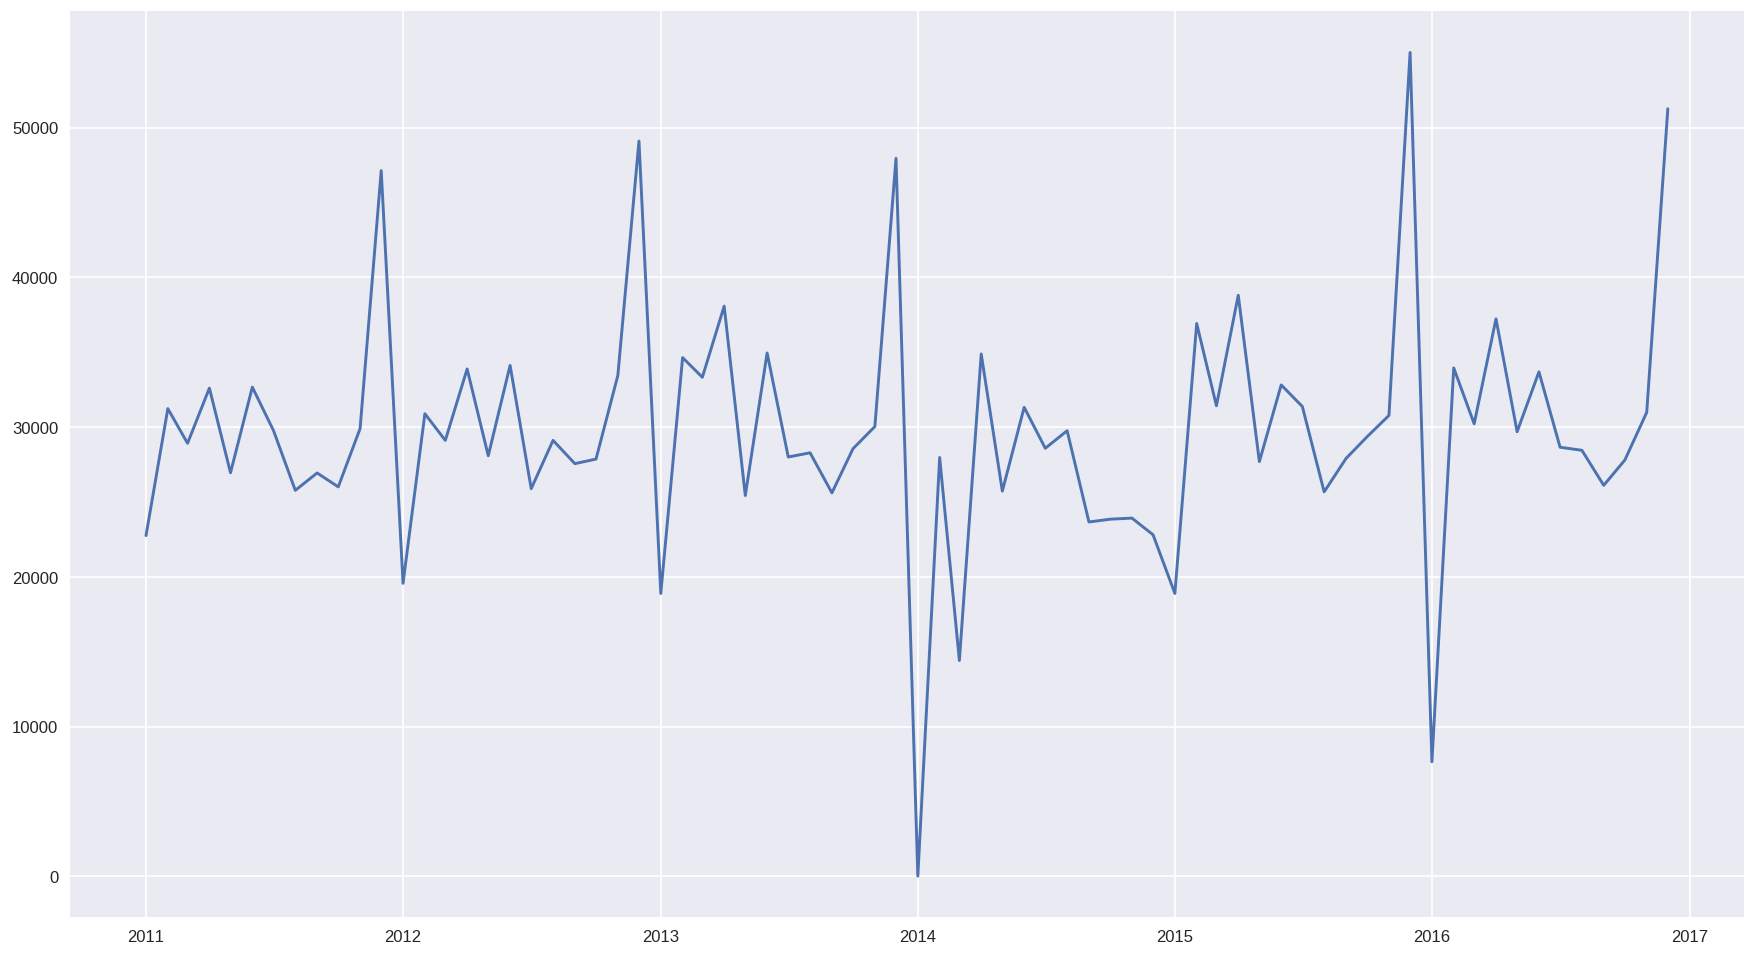

In [474]:
sns.lineplot(x=df_train.index, 
             y=boxcox(df_train.target)[0],
             data=df_train);

In [475]:
kpss_test(boxcox(df_train.target)[0])

'KPSS тест не отвергает гипотезу о стационарности, Статистика 0.082 > критического значения 0.463, p_value 0.1 < 0.05'

In [476]:
adfuller_test(boxcox(df_train.target)[0])

'Тест Дикки-Фуллера отвергает гипотезу о стационарности ряда, Статистика -1.537 > критического значения -2.912, p_value: 0.515'

Стало хуже

In [477]:
data = df_train.target

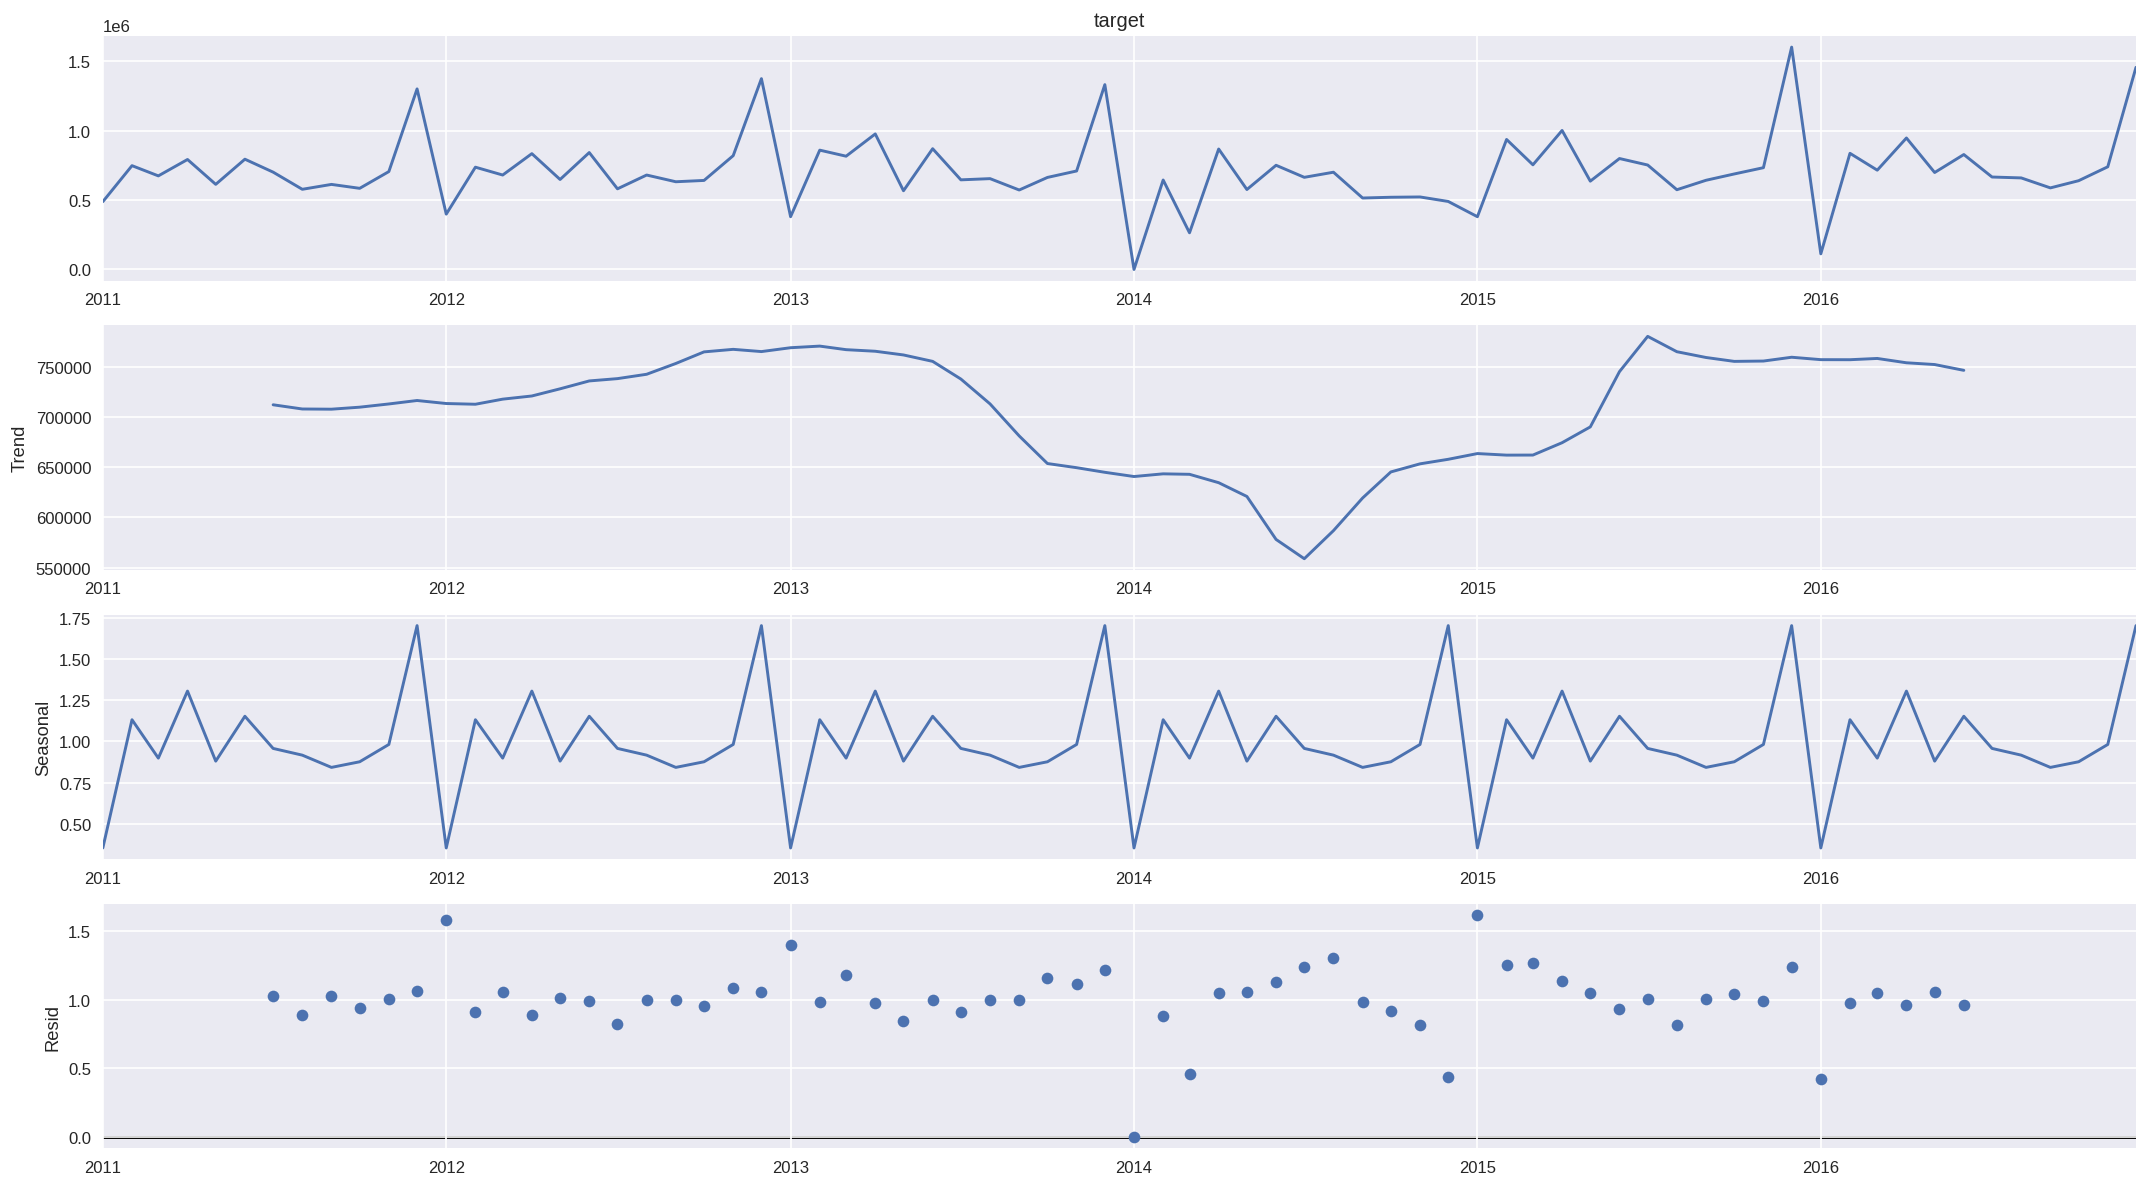

In [478]:
decompose_result = seasonal_decompose(data, model='multiplicative')
decompose_result.plot();

In [479]:
def mk_test(ts, mode = 'simple', window = 50, alpha = 0.00001):
    """
    Mann-Kendall test for trend
    Detects linear trends (in pair with cox_stuart)
    Optimal window = 50
    Input:
        x:   a vector of data
        alpha: significance level (0.001 default)
        window: last n values, for finding trend
        mode: 
            - 'full' - if you need to know trend direction; 
            - 'simple' - if just trend existance.
    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 
    """
    x = [x if x else 0 for x in ts[-window:]]
    n = len(x)

    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])
    #s = [-1 if x[j] < x[k] else 1 for j in range(k+1,n) for k in range(n-1)]

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)
    # calculate the var(s)
    n = float(n)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
#         print(var_s)
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test

    h = abs(z) > norm.ppf(1-alpha/2) 

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'
    if mode == 'full':
        return trend, h, p, z
    else:
#         return h, abs(z)
        return f'z: {abs(z)}, norm: {norm.ppf(1-alpha/2)}, {h}'

In [480]:
# kendalltau(y, y)

In [481]:
# spearmanr(y, y)

In [482]:
mk_test(df_train.target, mode = 'simple', window = 72, alpha = 0.05)

'z: 0.5882108973327478, norm: 1.959963984540054, False'

In [483]:
def abbe_criterion(timeseries, window = 40, alpha = .00001, debug = False):

    """
    Abbe-Linnik criterion
    Detects exponential trend (in pair with autocorrelation)
    If window >50 => too much True
    """
    if len(timeseries) < window:
        return False
    series = pd.Series([x if x else 0 for x in timeseries])
    a = series[-window:]
    mean = a.mean()
    

    X = zip(a[:-1],a[1:])
    s1 = sum([math.pow((x[0]-x[1]),2) for x in X])
    s2 = sum([pow((x-mean),2) for x in a])
    q = 0.5 * s1 / s2
    q_a = 0.6814
    n = len(a)
    Q = -(1-q)*math.sqrt((2*n+1)/(2-pow((1-q),2)))
    u = norm.ppf(alpha) #kobzar page 26
    if debug:
        print ('mean:', mean)
        print ('q:', q)
        print ('Q*:', Q)
        print ('U_alpha-1:', u)
    return f'Q: {Q}, u: {u}, {Q < u}'
# , {abs(Q)}'

In [484]:
abbe_criterion(df_train.target, window = 72, alpha = .05, debug = False)

'Q: 1.8766812708751064, u: -1.6448536269514729, False'

In [485]:
def cox_stuart(timeseries, window = 50, alpha = 0.0001, debug = False):
    """
    Cox-Stuart criterion
    H0: trend exists
    H1: otherwise
    Detects linear trends
    Optimal window = 50
    """
    n = window
    idx = np.arange(1,n+1)
    X = pd.Series([x if x else 0 for x in timeseries[-n:]], index=idx)
    
    S1 = [(n-2*i) if X[i] <= X[n-i+1] else 0 for i in range(1,n//2)]
    n = float(n)
    S1_ = (sum(S1) - n**2 / 8) / math.sqrt(n*(n**2-1)/24)
    u = norm.ppf(1-alpha/2)
    if debug:
        print('|S1*|:', abs(S1_))
        print("u:",u)
    
    return abs(S1_) > u, abs(S1_) #H0 accept

In [486]:
cox_stuart(df_train.target, window = 72, alpha = 0.0001, debug = False)

(False, 0.09623432717286111)

Наличие выраженного тренда не подтвердилось.

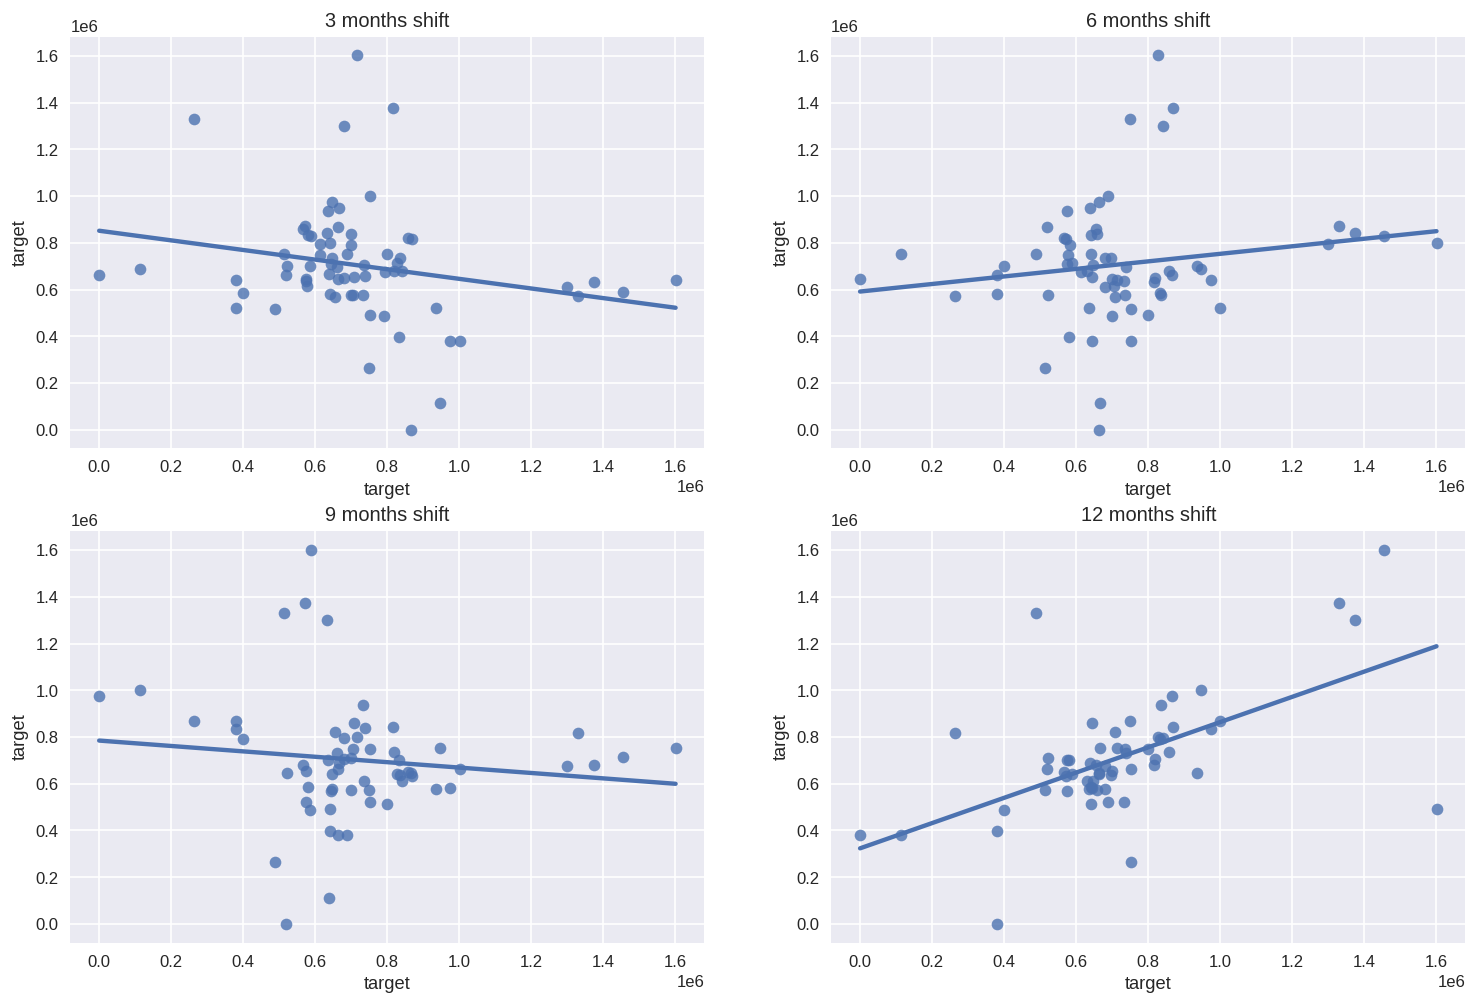

In [487]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,10))

sns.regplot(x = df_train.target, y = df_train.target.shift(3), data = df_train, ax=ax1, ci=None)
ax1.title.set_text('3 months shift')
sns.regplot(x = df_train.target, y = df_train.target.shift(6), data = df_train, ax=ax2, ci=None)
ax2.title.set_text('6 months shift')
sns.regplot(x = df_train.target, y = df_train.target.shift(9), data = df_train, ax=ax3, ci=None)
ax3.title.set_text('9 months shift')
sns.regplot(x = df_train.target, y = df_train.target.shift(12), data = df_train, ax=ax4, ci=None)
ax4.title.set_text('12 months shift');

In [488]:
# # Доверительный интервал
# n = 12
# lower_bound = -1.96 * 1/ n*0.5
# upper_bound =  1.96 * 1/ n*0.5
# print(lower_bound, upper_bound)

In [489]:
# Сдвиг / shift
df_train['target_bc_shift'] = df_train['target'].shift(12)

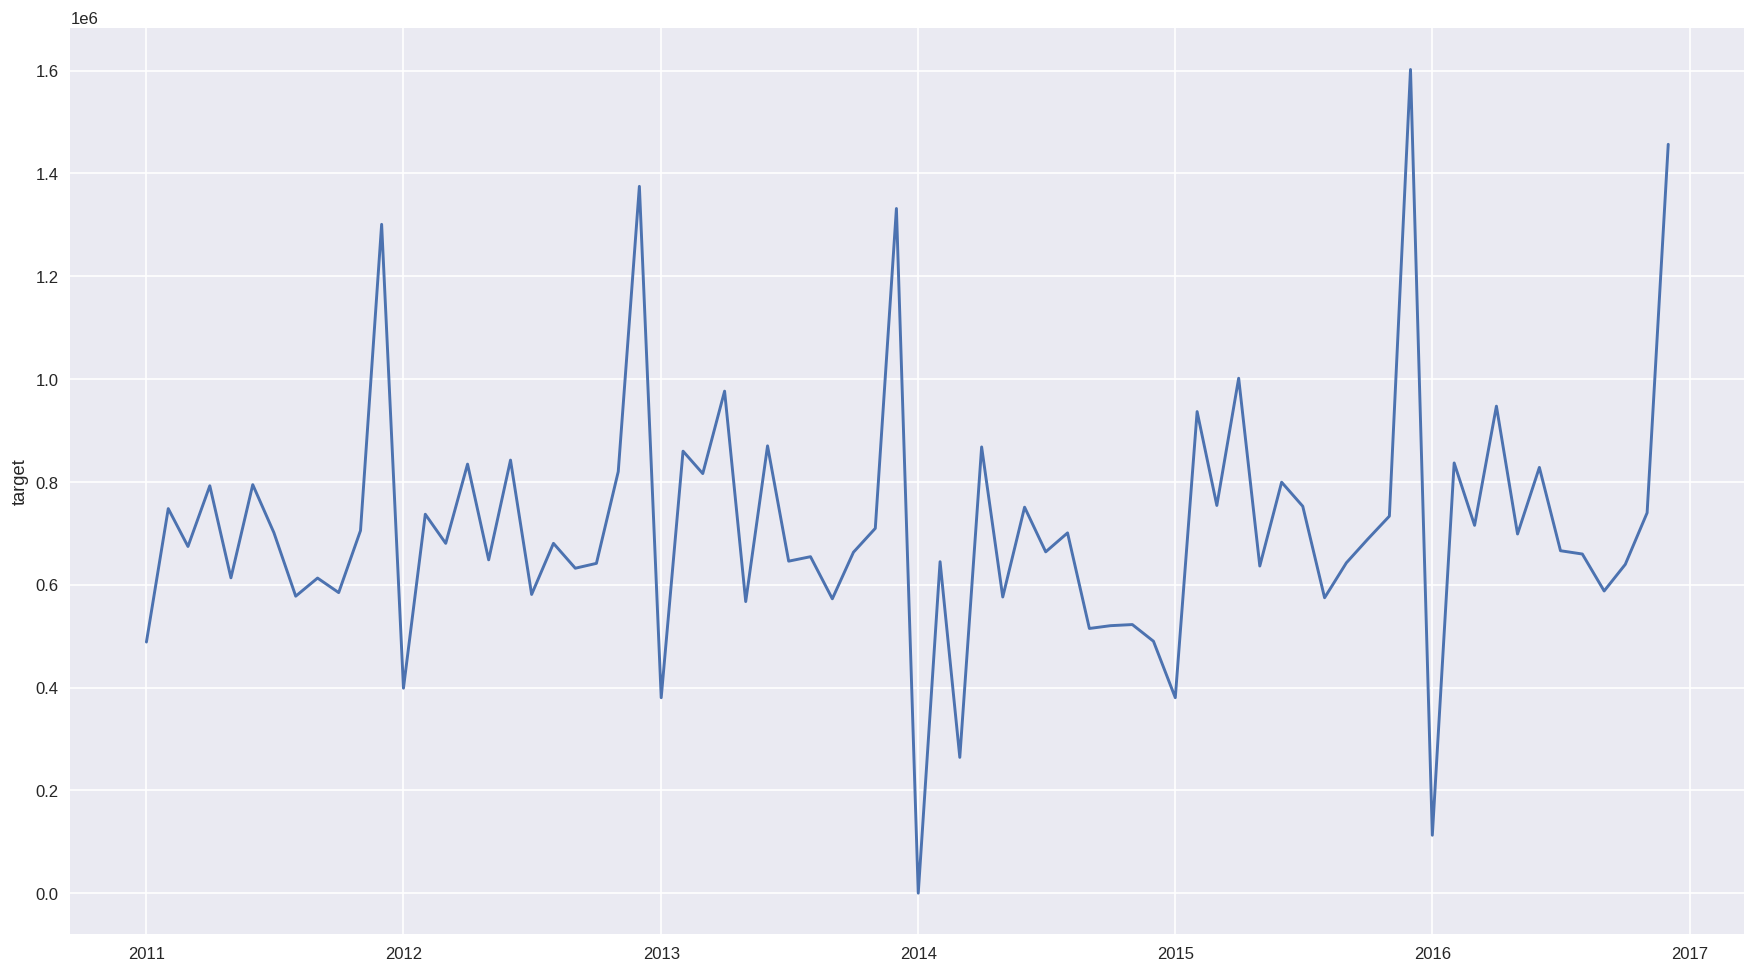

In [490]:
sns.lineplot(x=df_train.index, y="target", data=df_train);

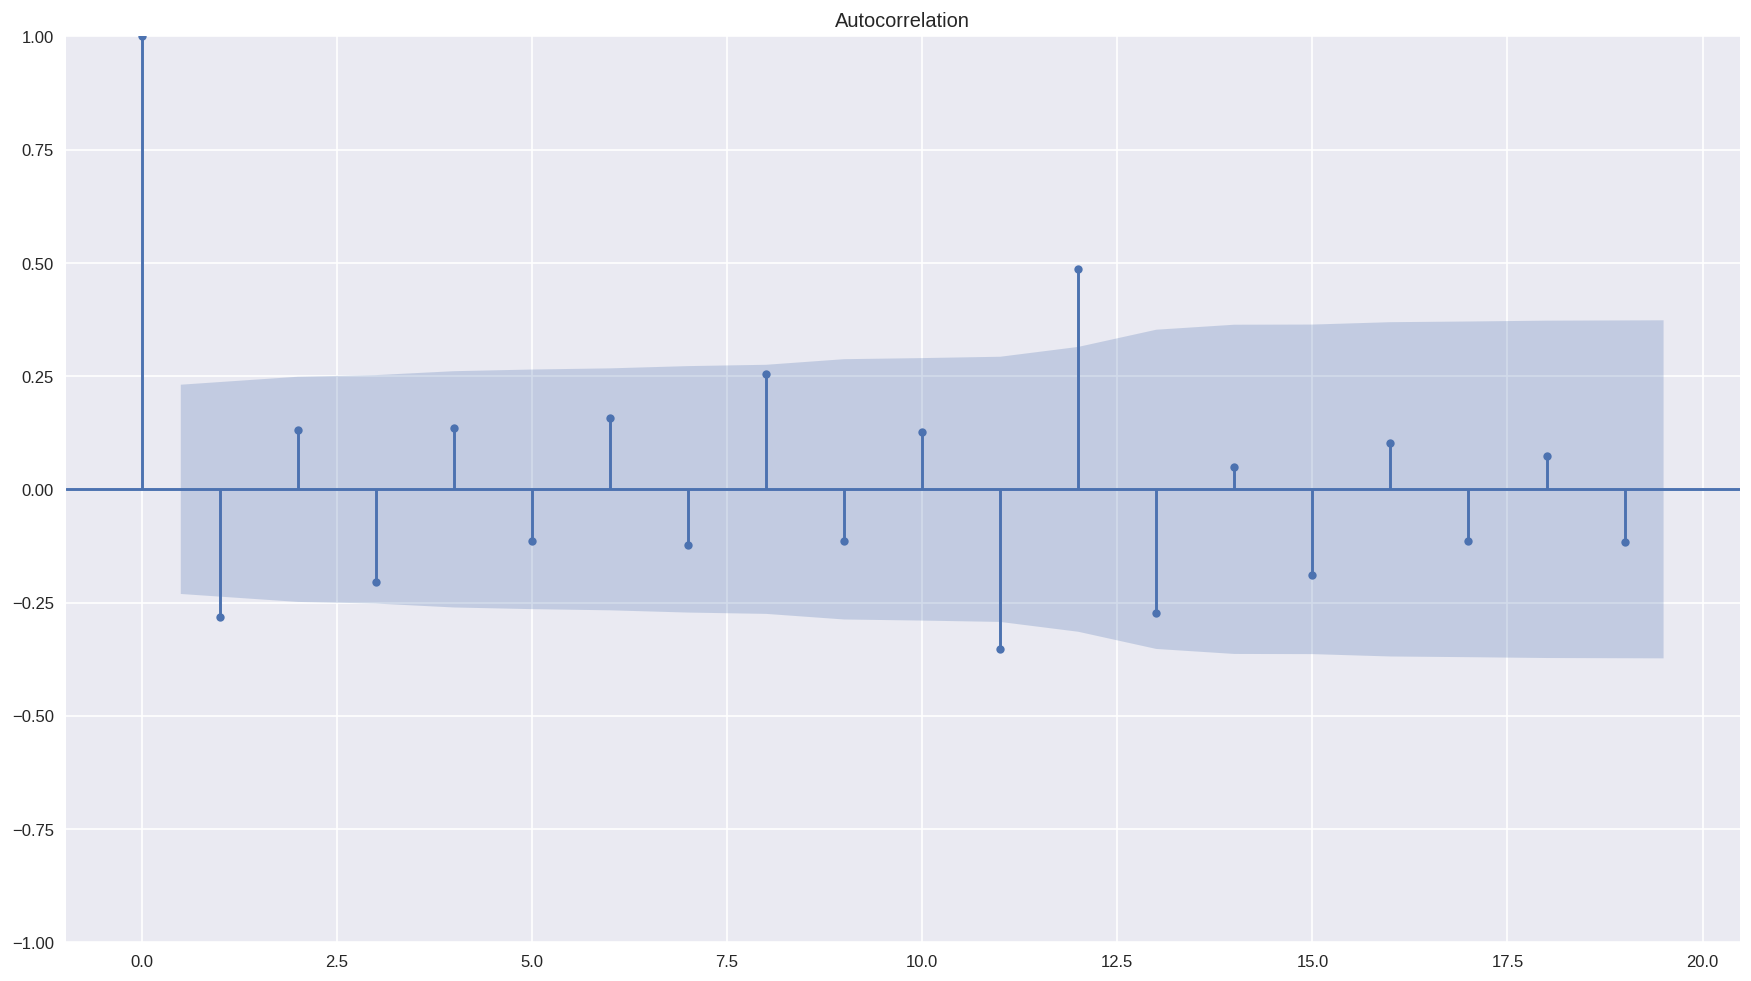

In [492]:
acf = plot_acf(df_train.target)

Синяя область - Коридор значимости критерия Стьюдента. Значимо отличаются от 0.

Значимо отличающиеся небольшие автокорреляции при больших лагах происходят благодаря множественной проверке гипотез.

Поэтому автокорреляцию 1 месяц и 11 месяцев мы игнорируем.

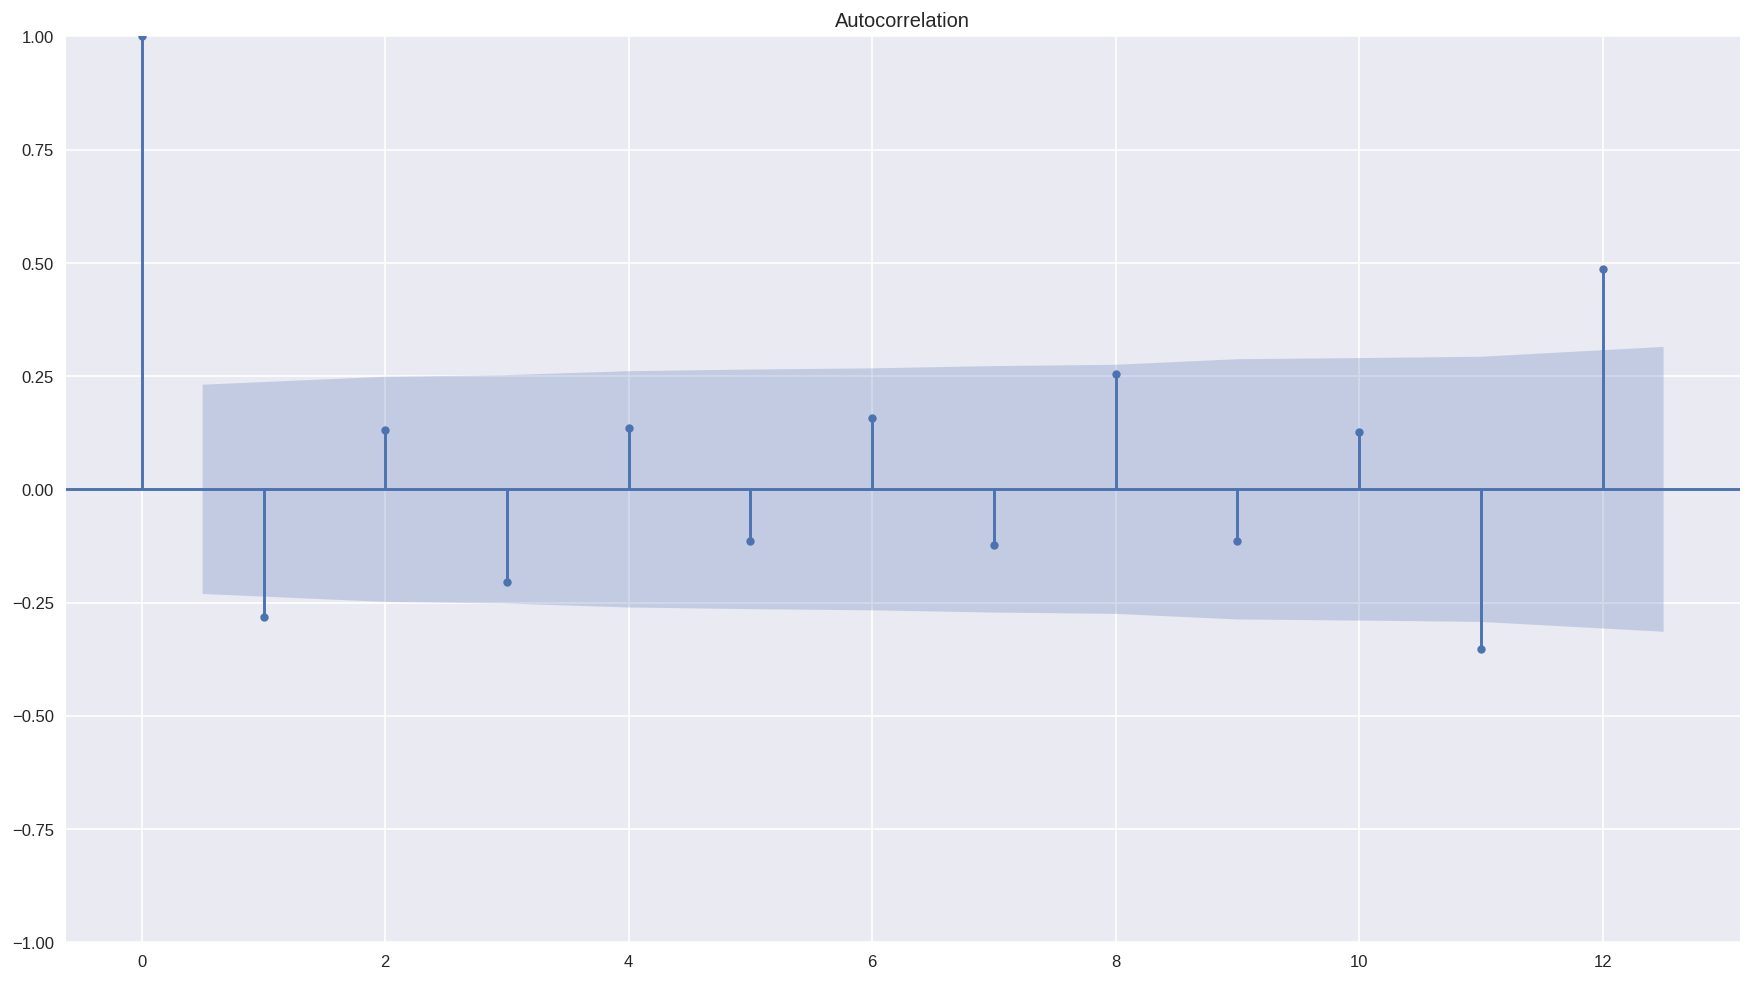

In [493]:
n_lags = 12
acf = plot_acf(df_train.target, lags=n_lags)

In [494]:
# Статистика Дарбина Уотсона в диапазоне от 0 до 4. Чем ближе к 0, тем более выраженная автокорреляция

durbin_watson(df_train.target, axis=0)

0.2804009068890242

Все данные указывают на довольно выраженную сезонность 12 месяцев.

### Сезонное дифференцирование

In [495]:
df_train['target_season'] = df_train.target - df_train.target.shift(12)

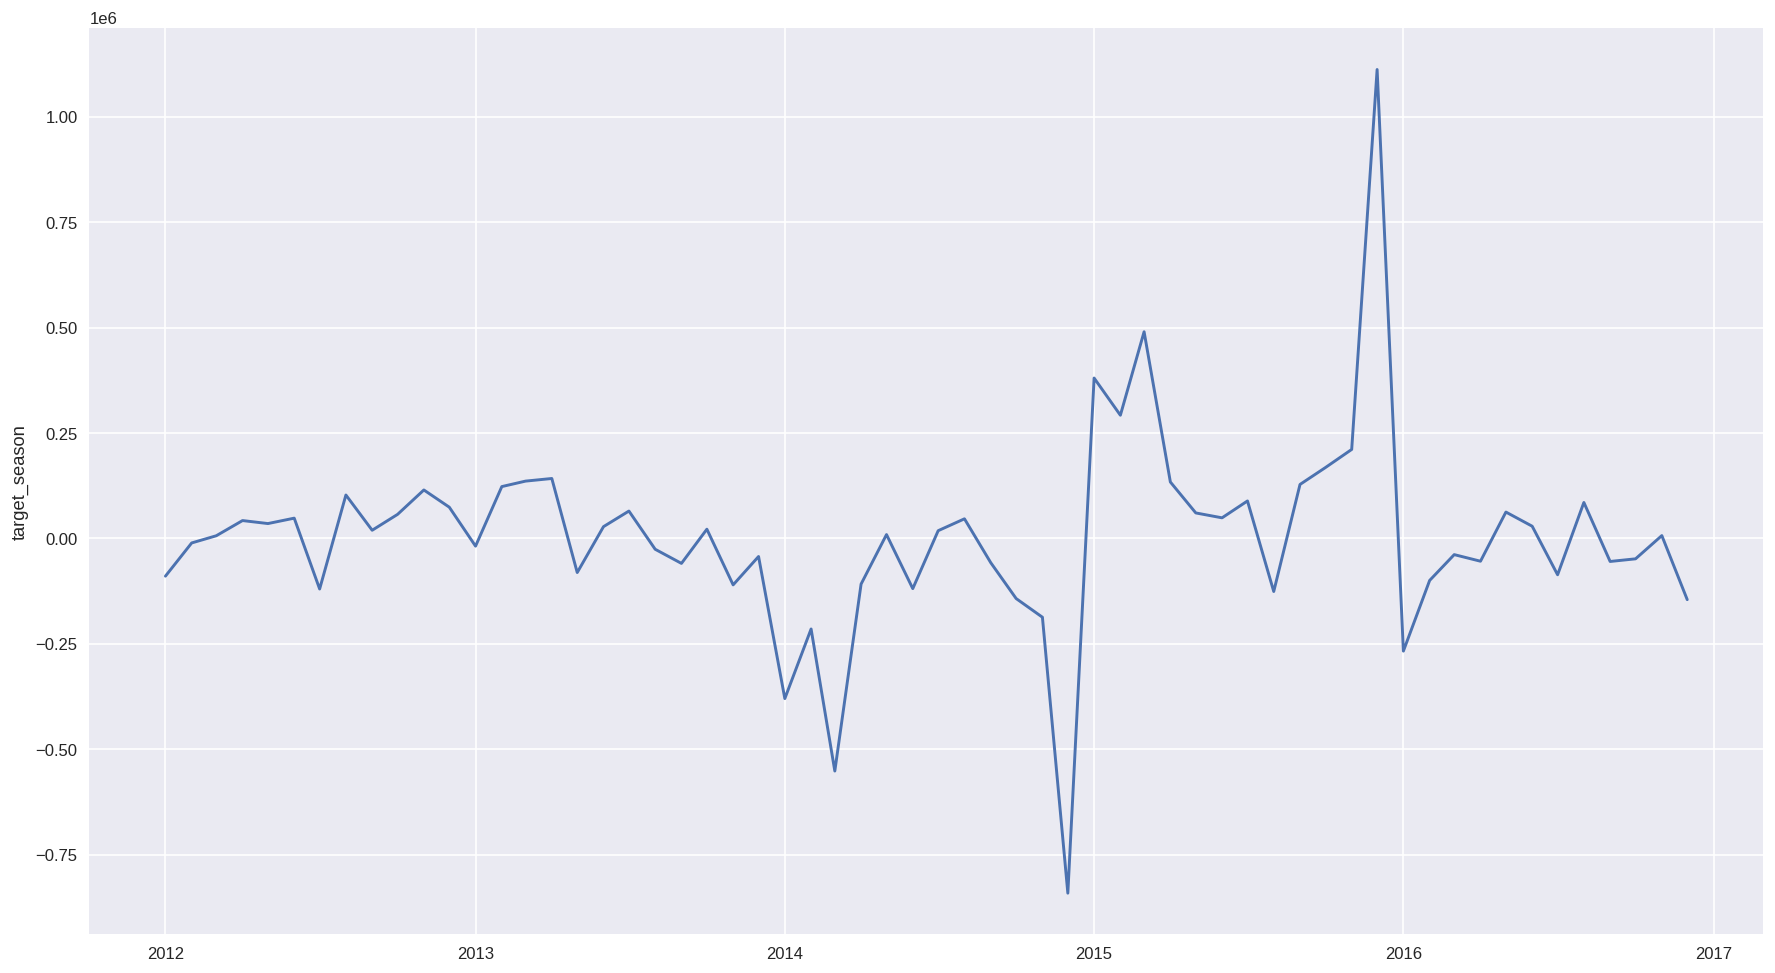

In [496]:
sns.lineplot(x=df_train.index, y="target_season", data=df_train);

In [497]:
data = df_train[12:].target_season
kpss_test(data)

'KPSS тест не отвергает гипотезу о стационарности, Статистика 0.122 > критического значения 0.463, p_value 0.1 < 0.05'

In [498]:
adfuller_test(data)

'Тест Дикки-Фуллера отвергает гипотезу о стационарности ряда, Статистика -2.637 > критического значения -2.924, p_value: 0.085'

Мы приближаемся к стационарному ряду

In [499]:
df_train['target_season_final'] = df_train.target - df_train.target.shift(12) + df_train.target.shift(11)

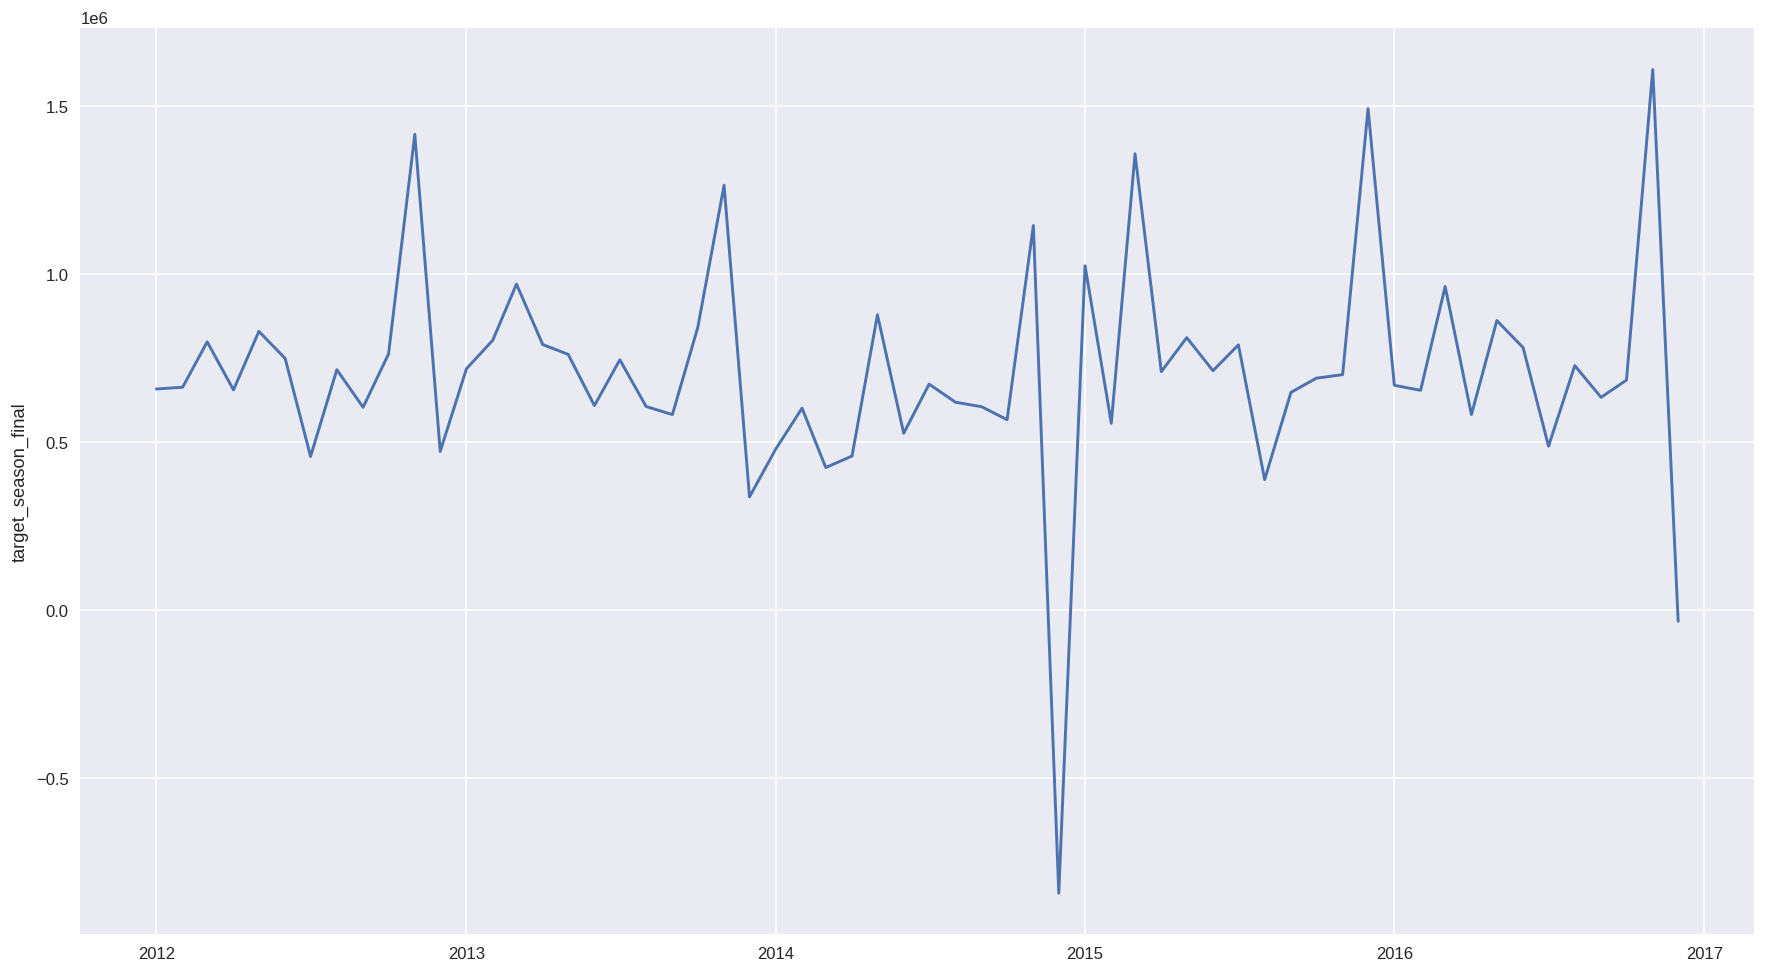

In [500]:
sns.lineplot(x=df_train.index, y="target_season_final", data=df_train);

In [501]:
data = df_train[12:].target_season_final

In [502]:
adfuller_test(data)

'Тест Дикки-Фуллера не отвергает гипотезу о стационарности ряда, Статистика -10.411 < критического значения -2.912, p_value: {round(p_value,3)}'

Ура! Ряд стационарен!

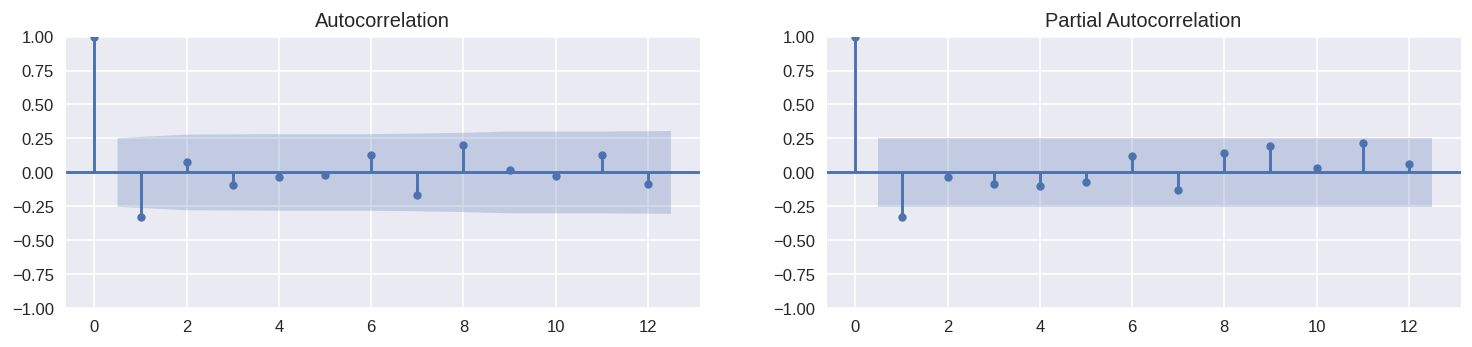

In [503]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))
n_lags = 12
acf = plot_acf(data, ax=ax1, lags=n_lags)
pacf = plot_pacf(data, ax=ax2, lags=n_lags)

In [566]:
df_train.iloc[:, :12].tail(15)

,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, руб","М2, руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб",target
2015-10-01,120663.0,10.390909,11.0,1.70,6.92,48.12,154.61269,7947900.0,32170.2,63.07,33357,688121.0
2015-11-01,165837.0,10.300000,11.0,1.65,7.45,44.42,155.77228,7942500.0,32754.2,65.03,33347,733295.0
2015-12-01,1034556.0,10.520000,11.0,1.68,8.43,37.72,156.97173,8745900.0,35179.7,69.66,43408,1602014.0
2016-01-01,-454791.0,10.308889,11.0,1.58,8.20,30.80,158.47866,8197700.0,33966.5,76.25,32660,112667.0
2016-02-01,269297.0,9.930476,11.0,1.62,7.68,33.20,159.47707,8282800.0,34309.6,77.22,33873,836755.0
2016-03-01,147971.0,9.505909,11.0,1.59,7.46,39.07,160.21067,8224700.0,34689.4,70.47,35501,715429.0
2016-04-01,379759.0,9.701905,11.0,1.30,7.67,42.25,160.91559,8482400.0,35105.5,66.68,36497,947217.0
2016-05-01,131129.0,9.538947,11.0,1.19,7.04,47.13,161.57535,8371900.0,35642.9,65.66,37270,698587.0
2016-06-01,260591.0,9.752857,10.5,0.97,6.92,48.48,162.15702,8471900.0,35856.9,65.31,38447,828049.0
2016-07-01,98589.0,9.606667,10.5,0.87,6.78,45.07,163.03267,8555200.0,36031.7,64.33,35888,666047.0


In [505]:
df_train['ofz_lag12'] = df_train['Доходность ОФЗ по сроку до 1 года'].shift(12)
df_train['key'] = df_train['Ключевая ставка'].shift(12)
df_train['deposit_key_doll_1year_lag12'] = df_train['Ставка по вкладам в долларах до 1 года'].shift(12)
# df_train['deposit_key_rub_1year_lag12'] = df_train['Ставка по вкладам в рублях до 1 года'].shift(12)
df_train['gas_urals_price_per_barr_lag12'] = df_train['Нефть марки Юралс, долл./барр'].shift(12)
df_train['price_index_lag12'] = df_train['Индекс потребительских цен, ед.'].shift(12)
df_train['M0_lag12'] = df_train['М0, руб'].shift(12)
df_train['M2_lag12'] = df_train['М2, руб'].shift(12)
df_train['doll_rub_lag12'] = df_train['Курс доллара к рублю, руб'].shift(12)
df_train['nominal_salary_lag12'] = df_train['Номинальная средняя з/п, руб'].shift(12)

In [506]:
df_train.columns

Index(['Прирост вкладов физических лиц в рублях (млн руб)',
       'Доходность ОФЗ по сроку до 1 года', 'Ключевая ставка',
       'Ставка по вкладам в долларах до 1 года',
       'Ставка по вкладам в рублях до 1 года', 'Нефть марки Юралс, долл./барр',
       'Индекс потребительских цен, ед.', 'М0, руб', 'М2, руб',
       'Курс доллара к рублю, руб', 'Номинальная средняя з/п, руб', 'target',
       'target_bc_shift', 'target_season', 'target_season_final', 'ofz_lag12',
       'key', 'deposit_key_doll_1year_lag12', 'gas_urals_price_per_barr_lag12',
       'price_index_lag12', 'M0_lag12', 'M2_lag12', 'doll_rub_lag12',
       'nominal_salary_lag12'],
      dtype='object')

In [507]:
X_train = df_train.iloc[12:-12,-12:].drop(['target_season', 'target_season_final'], axis = 1)
y_train = df_train.iloc[12:-12,-10:-9]

In [508]:
X_valid = df_train.iloc[-12:,-12:].drop(['target_season', 'target_season_final'], axis = 1)
y_valid = df_train.iloc[-12:,-10:-9]

In [509]:
RFR = RandomForestRegressor()

In [510]:
RFR.fit(X_train, y_train)

RandomForestRegressor()

In [513]:
print("train acc:", mean_absolute_error(RFR.predict(X_train), y_train))
print("test acc:", mean_absolute_error(RFR.predict(X_valid), y_valid))

train acc: 94218.75166666666
test acc: 193872.34250000003


In [514]:
RFR.feature_importances_

array([0.35383517, 0.0799082 , 0.05538269, 0.04434535, 0.06047044,
       0.03275088, 0.11091526, 0.12570796, 0.06184857, 0.07483549])

In [516]:
# sns.lineplot(x=df_ttt.index, y="target_season_final", data=df_ttt)
# sns.lineplot(x=df_ttt.index, y="y_predict", data=df_ttt);

In [519]:
# метрика регрессии
def rmse(y_true, y_pred):
    return np.sqrt(np.sum((y_true - y_pred)**2)/len(y_true))

In [520]:
# Значение метрики RMSE для RFR
print(round(rmse(RFR.predict(X_train), y_train['target_season_final']), 1))
print(round(rmse(RFR.predict(X_valid), y_valid['target_season_final']), 1))

161688.0
303550.3


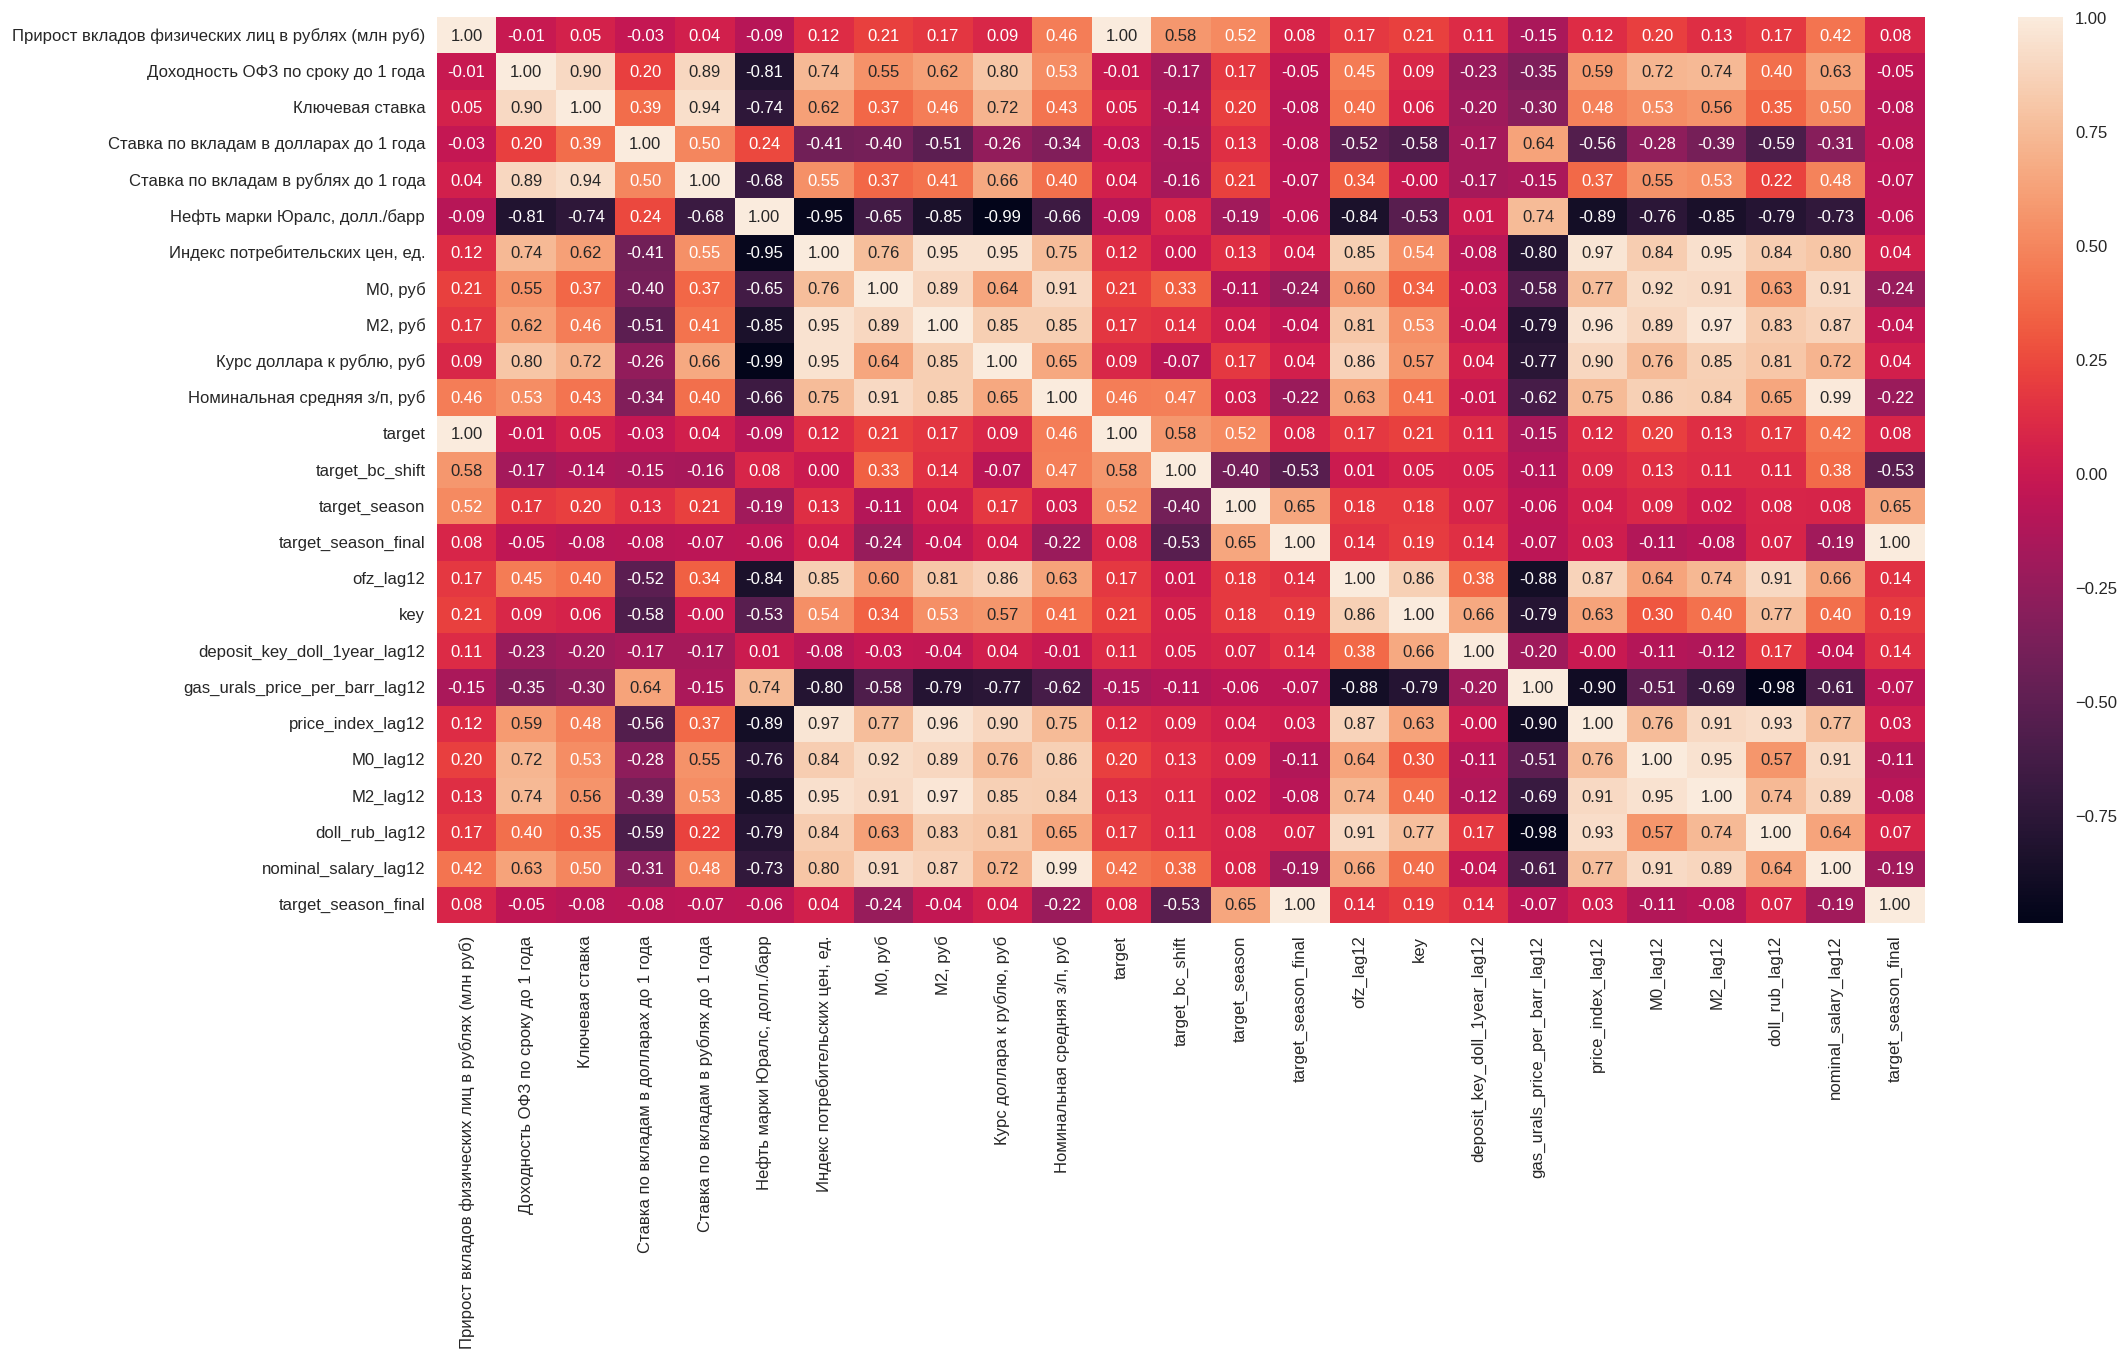

In [518]:
plt.figure(figsize=(20,10))
sns.heatmap(
    pd.concat([df_train.iloc[12:,:], df_train['target_season_final']], axis=1).corr(),
    annot=True,
    fmt='.2f'
);

In [721]:
df_train['Номинальная средняя з/п, руб'].tail(15)

2015-10-01    33357
2015-11-01    33347
2015-12-01    43408
2016-01-01    32660
2016-02-01    33873
2016-03-01    35501
2016-04-01    36497
2016-05-01    37270
2016-06-01    38447
2016-07-01    35888
2016-08-01    35405
2016-09-01    35843
2016-10-01    35749
2016-11-01    36195
2016-12-01    47554
Name: Номинальная средняя з/п, руб, dtype: int64

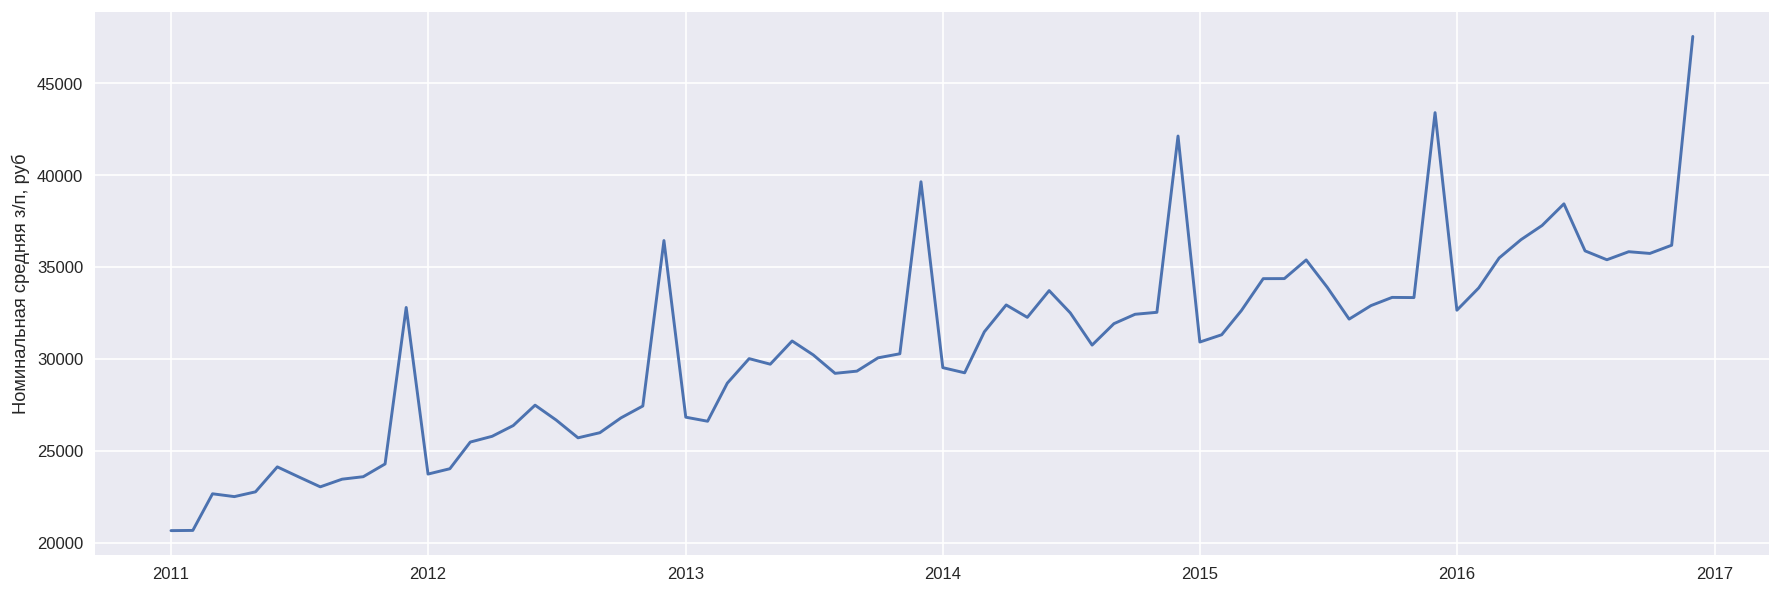

In [644]:
sns.lineplot(x=df_train.index, y="Номинальная средняя з/п, руб", data=df_train);

In [645]:
adfuller_test(df_train.target)

'Тест Дикки-Фуллера отвергает гипотезу о стационарности ряда, Статистика -1.562 > критического значения -2.912, p_value: 0.502'

In [686]:
model = ExponentialSmoothing(df['Номинальная средняя з/п, руб'], seasonal_periods= 12, trend='add', seasonal='add')
fitted_model = model.fit()
exp_pred = fitted_model.predict(start='2016-01-01', end='2016-12-01')

In [759]:
df_train['salary_pred'] = df_train['Номинальная средняя з/п, руб']
df_train.iloc[-12:,-1] = pd.DataFrame(exp_pred)

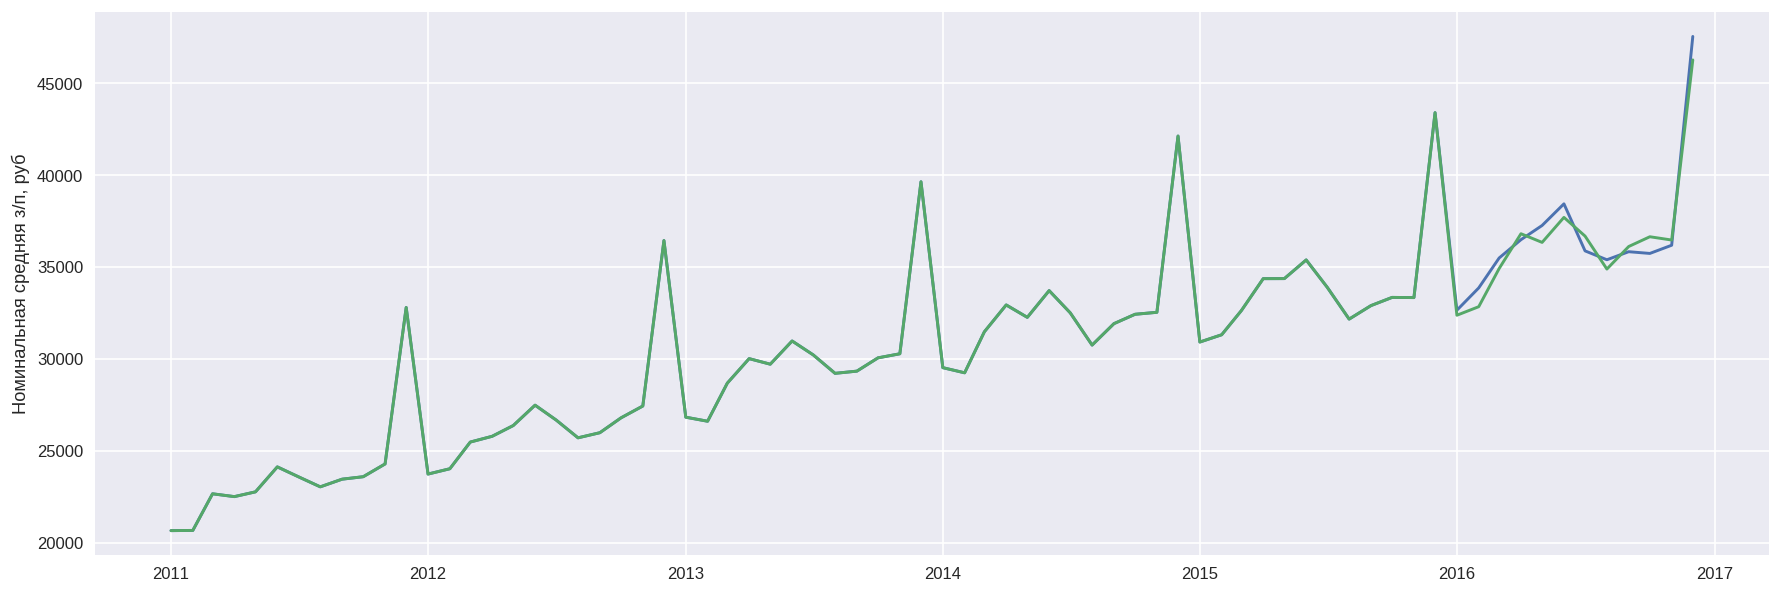

In [761]:
sns.lineplot(x=df_train.index, y="Номинальная средняя з/п, руб", data=df_train)
sns.lineplot(x=df_train.index, y="salary_pred", data=df_train);

In [763]:
df_train.columns

Index(['Прирост вкладов физических лиц в рублях (млн руб)',
       'Доходность ОФЗ по сроку до 1 года', 'Ключевая ставка',
       'Ставка по вкладам в долларах до 1 года',
       'Ставка по вкладам в рублях до 1 года', 'Нефть марки Юралс, долл./барр',
       'Индекс потребительских цен, ед.', 'М0, руб', 'М2, руб',
       'Курс доллара к рублю, руб', 'Номинальная средняя з/п, руб', 'target',
       'target_bc_shift', 'target_season', 'target_season_final', 'ofz_lag12',
       'key', 'deposit_key_doll_1year_lag12', 'gas_urals_price_per_barr_lag12',
       'price_index_lag12', 'M0_lag12', 'M2_lag12', 'doll_rub_lag12',
       'nominal_salary_lag12', 'salary_pred'],
      dtype='object')

In [774]:
y_train = pd.DataFrame(df_train[12:]['target_season_final'])

In [795]:
X_train = pd.DataFrame(df_train['target_bc_shift'])
X_train['salary_pred'] = df_train['salary_pred']
X_train = y_train[:]

In [809]:
y_valid = pd.DataFrame(df_train[-12:]['target_season_final'])
X_valid = pd.DataFrame(df_train['target_bc_shift'])
X_valid['salary_pred'] = df_train['salary_pred']
X_valid = y_train[-12:]

In [810]:
X_valid

,target_season_final
2016-01-01,669115.0
2016-02-01,654197.0
2016-03-01,962876.0
2016-04-01,581979.0
2016-05-01,861618.0
2016-06-01,781240.0
2016-07-01,488102.0
2016-08-01,727691.0
2016-09-01,633224.0
2016-10-01,684669.0


In [811]:
RFR = RandomForestRegressor()

In [812]:
RFR.fit(X_train, y_train)

RandomForestRegressor()

In [813]:
df_train['target_season_final'][-12:]

2016-01-01     669115.0
2016-02-01     654197.0
2016-03-01     962876.0
2016-04-01     581979.0
2016-05-01     861618.0
2016-06-01     781240.0
2016-07-01     488102.0
2016-08-01     727691.0
2016-09-01     633224.0
2016-10-01     684669.0
2016-11-01    1608500.0
2016-12-01     -32804.0
Name: target_season_final, dtype: float64

In [815]:
pd.DataFrame(RFR.predict(X_valid))

,0
0,668919.83
1,655008.10
2,963884.68
3,581679.20
4,861744.46
5,783426.89
6,483564.96
7,723885.27
8,630569.06
9,685055.29


In [816]:
print(round(rmse(RFR.predict(X_valid), y_valid['target_season_final']), 1))

44972.5


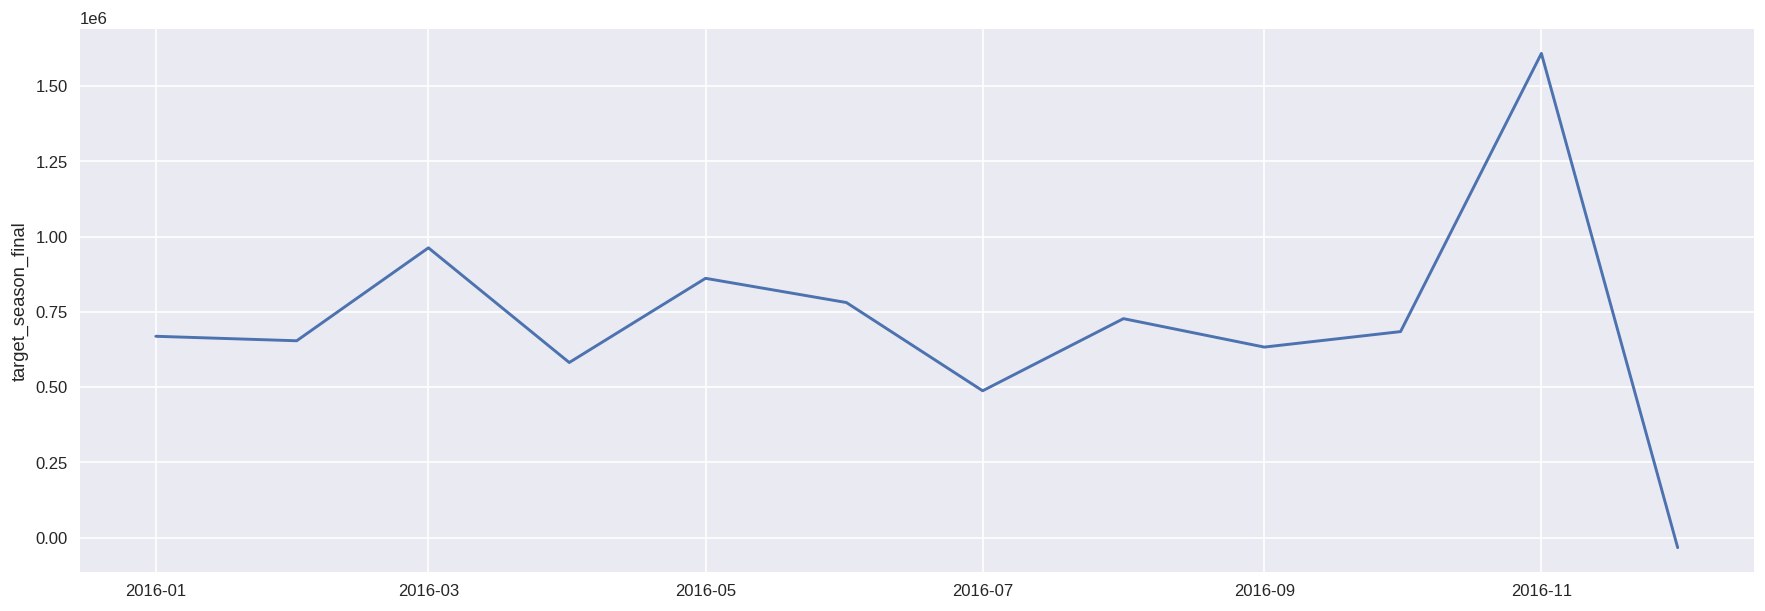

In [817]:
sns.lineplot(x=df_train[-12:].index, y="target_season_final", data=df_train[-12:]);

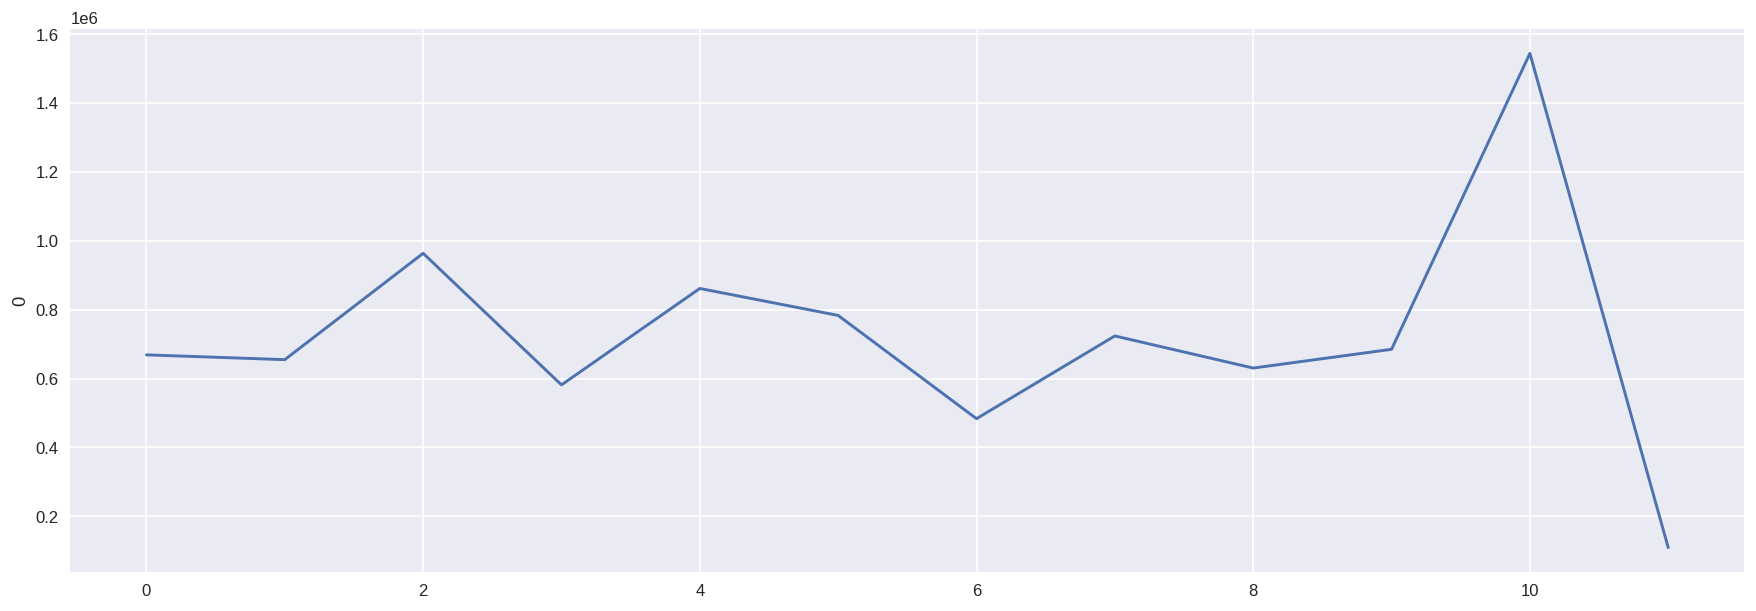

In [818]:
# data = pd.DataFrame(RFR.predict(X_valid)
sns.lineplot(x=pd.DataFrame(RFR.predict(X_valid)).index, y=0, data=pd.DataFrame(RFR.predict(X_valid)));